# Clusters de datos demográficos y emociones sobre las obras (Kmeans) etiquetados con FCA

## Carga de los datos
Cargamos los datos y retocamos algún campo. Preparamos el dataFrame con la valoración que tiene cada usuario de una categoría de cuadro.

In [1]:
import pandas as pd
import numpy as np 

In [2]:
Prado_users = pd.read_csv('../data/originales/Prado_users.csv')
Prado_emotions = pd.read_csv('../data/originales/Prado_emotions.csv')
Prado_artworks_wikidata = pd.read_csv('../data/originales/Prado_artworks_wikidata.csv')

Prado_users.replace('<12', '0-12', inplace=True)
Prado_users.replace('>70', '70+', inplace=True)
Prado_users.replace('Argenitina', 'Argentina', inplace=True)
Prado_users.replace('USA', 'United States', inplace=True)

users_val = Prado_users.copy()

users_val.head()

,userId,age,gender,country
0,1,55-64,male,Spain
1,2,25-34,female,Spain
2,3,18-24,female,Spain
3,4,18-24,female,Spain
4,5,35-44,male,Spain


In [3]:
# category valoration
for cat in Prado_artworks_wikidata['Category'].unique():
    users_val[cat]=np.zeros(users_val.shape[0])

Prado_emotions.replace('positive', 1., inplace=True)
Prado_emotions.replace('negative', -1., inplace=True)
Prado_emotions.replace('mixed', 0., inplace=True)

for i, row in Prado_emotions.iterrows():
    cat=Prado_artworks_wikidata.loc[Prado_artworks_wikidata['ID']==row['artworkId'], 'Category'].to_list()[0]
    users_val.loc[users_val['userId']==row['userId'], cat] += row['Polarity']

users = users_val.copy()
users_val.head()

,userId,age,gender,country,Romanticism,High Renaissance,Northern Renaissance,Baroque
0,1,55-64,male,Spain,2.0,0.0,-2.0,0.0
1,2,25-34,female,Spain,-1.0,0.0,0.0,0.0
2,3,18-24,female,Spain,3.0,0.0,-3.0,2.0
3,4,18-24,female,Spain,4.0,0.0,0.0,0.0
4,5,35-44,male,Spain,5.0,3.0,-1.0,0.0


## Propuesta de medidas de similitud para cada campo
- Para el campo de edad colocamos una distancia de uno entre cada rango de edad consecutivo
- Para el género utilizaremos 0 y 1 respectivamente
- Para el país utilizaremos el índice descrito en *Countries_distance.csv*

In [4]:
# Edad
age_index = 1
for age_range in users['age'].unique():
    users = users.replace(age_range, age_index)
    age_index += 1

# gender
users = users.replace('female', 0)
users = users.replace('male', 1)

# country
country_punctuation = pd.read_csv('../data/Countries_distance.csv')

for country in users['country'].unique():
    if country != 'Other':
        users = users.replace(country, country_punctuation.loc[country_punctuation['Country'] == country, 'Punctuation'].to_list()[0])
    

users = users.replace('Other', .70)


## Escalado de los datos

In [5]:
from sklearn.preprocessing import StandardScaler

scaled_users = users.copy()
scaled_users.drop('userId', axis=1, inplace=True)
#scaled_users.set_index('userId')

scaler = StandardScaler(with_mean=False, with_std=True)

scaled_users = pd.DataFrame(data=scaler.fit_transform(scaled_users), index=users['userId'], columns=scaled_users.columns.to_list())

scaled_users.head(10)

,age,gender,country,Romanticism,High Renaissance,Northern Renaissance,Baroque
userId,,,,,,,
1,0.500137,2.021723,2.508838,0.922735,0.000000,-0.652591,0.000000
2,1.000274,0.000000,2.508838,-0.461368,0.000000,0.000000,0.000000
3,1.500411,0.000000,2.508838,1.384103,0.000000,-0.978886,1.388913
4,1.500411,0.000000,2.508838,1.845470,0.000000,0.000000,0.000000
5,2.000547,2.021723,2.508838,2.306838,3.542399,-0.326295,0.000000
6,2.000547,0.000000,2.508838,2.306838,0.000000,1.957773,6.944567
7,2.500684,0.000000,2.508838,0.000000,1.180800,0.652591,0.694457
8,2.000547,0.000000,2.977269,3.690940,0.000000,1.631477,0.000000
9,3.000821,2.021723,2.508838,0.922735,0.000000,0.652591,0.000000


## Buscando el número óptimo de clusters
Aplicamos Kmeans con diferente número de clusters y evaluamos cual de ellos tiene el cociente *Davies–Bouldin* más bajo para utilizar ese número de conjuntos

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

MAX_CLUSTERS = 20
davies_boulding = np.zeros(MAX_CLUSTERS-2)

for k in range(2, MAX_CLUSTERS): 
    km = KMeans(init='k-means++', n_clusters=k, random_state=123)
    km.fit(scaled_users)
    davies_boulding[k-2] = davies_bouldin_score(scaled_users, km.labels_)


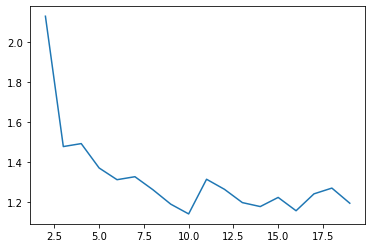

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(2, MAX_CLUSTERS), davies_boulding)

## Creamos el número óptimo de clusters

In [8]:
# Realizamos el clustering con el número óptimo de clusters
km = KMeans(init='k-means++', n_clusters=davies_boulding.argmin()+2, random_state=333)
km.fit(scaled_users)


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=333, tol=0.0001, verbose=0)

# Etiquetado de los clusters con FCA
Primero, vamos a recabar todos los datos en un nuevo DataFrame que incluya a que cluster pertenece cada usuario

In [9]:
clustered_users = users_val.copy()
clustered_users['cluster'] = km.labels_
clustered_users.head(10)

,userId,age,gender,country,Romanticism,High Renaissance,Northern Renaissance,Baroque,cluster
0,1,55-64,male,Spain,2.0,0.0,-2.0,0.0,2
1,2,25-34,female,Spain,-1.0,0.0,0.0,0.0,1
2,3,18-24,female,Spain,3.0,0.0,-3.0,2.0,4
3,4,18-24,female,Spain,4.0,0.0,0.0,0.0,4
4,5,35-44,male,Spain,5.0,3.0,-1.0,0.0,3
5,6,35-44,female,Spain,5.0,0.0,6.0,10.0,7
6,7,65-70,female,Spain,0.0,1.0,2.0,1.0,8
7,8,35-44,female,United States,8.0,0.0,5.0,0.0,4
8,9,45-54,male,Spain,2.0,0.0,2.0,0.0,6
9,10,35-44,male,Other,-3.0,0.0,2.0,0.0,0


### *Convertimos las variables categóricas en otras de tipo binario*
Para poder generar un concept lattice hemos de partir de un conjunto de variables binarias. Para ello hemos de pasar de variables categóricas a variables binarias mediante funciones de pertenencia a cada posible valor de las mismas.

In [10]:
def categoricColumnsToBinary(df, columns=list()):
    for column in columns:
        for key in df[column].unique():
            df[key] = ''
            df.loc[df[column] == key, key] = 'X'

        df.drop([column], axis=1, inplace=True)


In [11]:
def columnToBinaryByCondition(df, columns=list(), cond=(lambda x : True)):
    for column in columns:
        df.loc[cond(df[column]), column] = 'X'
        df.loc[df[column] != 'X', column] = ''
        

In [12]:
clustered_users_context = clustered_users.copy()

age = clustered_users_context['age'].unique()
age.sort()
age = age.reshape(3,3)
ageRanges = { 'young' : ["0-12", "13-17"],
              'youg-adult': ["18-24","25-34"],
              'adult' : ["35-44","45-54","55-64"],
              'senior' : ["65-70", "70+"]}

ranges = {}
for key in ageRanges:
    for i in ageRanges[key]:
        ranges[i] = key

for key in ranges:
    clustered_users_context.replace(key, ranges[key], inplace=True)

categoricColumnsToBinary(clustered_users_context, ['age', 'country', 'gender'])
columnToBinaryByCondition(clustered_users_context, columns=Prado_artworks_wikidata['Category'].unique(), cond=(lambda x: x > 0.))

clustered_users_context.head(10)

,userId,Romanticism,High Renaissance,Northern Renaissance,Baroque,cluster,adult,youg-adult,senior,young,...,Mexico,France,Japan,Brazil,Italy,Germany,Argentina,Canada,male,female
0,1,X,,,,2,X,,,,...,,,,,,,,,X,
1,2,,,,,1,,X,,,...,,,,,,,,,,X
2,3,X,,,X,4,,X,,,...,,,,,,,,,,X
3,4,X,,,,4,,X,,,...,,,,,,,,,,X
4,5,X,X,,,3,X,,,,...,,,,,,,,,X,
5,6,X,,X,X,7,X,,,,...,,,,,,,,,,X
6,7,,X,X,X,8,,,X,,...,,,,,,,,,,X
7,8,X,,X,,4,X,,,,...,,,,,,,,,,X
8,9,X,,X,,6,X,,,,...,,,,,,,,,X,
9,10,,,X,,0,X,,,,...,,,,,,,,,X,


### *Creamos los retículos de cada cluster a partir del contexto formal anterior*

In [13]:
from concepts import Context

clusterLattices = list()

for c in clustered_users_context['cluster'].unique():
    # Separamos las filas que pertenecen al cluster
    clusterContext = clustered_users_context[clustered_users_context['cluster'] == c]
    clusterContext.drop(['cluster'], axis=1, inplace=True)
    # Generamos el retículo correspondiente al cluster
    clusterLattices.append(Context.fromstring(clusterContext.to_csv(index=False), frmat='csv'))

In [14]:
i = 0
for lattice in clusterLattices:
    print('\nCluster %i:' % (i))
    for extent, intent in lattice.lattice:
        if len(intent) >= 4:
            print(intent, len(extent))
    i+=1



Cluster 0:
('Romanticism', 'High Renaissance', 'Northern Renaissance', 'Baroque', 'adult', 'youg-adult', 'senior', 'young', 'Spain', 'United States', 'Other', 'Mexico', 'France', 'Japan', 'Brazil', 'Italy', 'Germany', 'Argentina', 'Canada', 'male', 'female') 0
('Romanticism', 'Northern Renaissance', 'Baroque', 'adult', 'Spain', 'male') 1
('Romanticism', 'Northern Renaissance', 'Baroque', 'youg-adult', 'Japan', 'male') 1
('Northern Renaissance', 'adult', 'Italy', 'male') 1
('Northern Renaissance', 'Baroque', 'adult', 'France', 'male') 1
('Northern Renaissance', 'Baroque', 'youg-adult', 'Canada', 'male') 1
('Romanticism', 'Northern Renaissance', 'Baroque', 'adult', 'Japan', 'male') 1
('Romanticism', 'Northern Renaissance', 'Baroque', 'youg-adult', 'France', 'male') 1
('Baroque', 'youg-adult', 'United States', 'male') 1
('Romanticism', 'Northern Renaissance', 'adult', 'France', 'male') 1
('Romanticism', 'Northern Renaissance', 'adult', 'United States', 'male') 1
('High Renaissance', 'Nor